# Pakistan Super League (PSL) — Match Winner Prediction


Goal: Build a model to predict the winning team for PSL matches

Table of Contents:
 - Load the PSL dataset (from Kaggle link: https://www.kaggle.com/datasets/brandmustafa/pakistan-super-league/data)
 - Preprocess features
 - Perform EDA (basic)
 - Train classification models to predict the match winner
 - Evaluate models with confusion matrix and classification report
 - Show prediction function for unseen data
 - Save trained model and preprocessing pipeline



# **Imports & Setup**


In [104]:
# ===== 1) Imports and setup =====
import os
import re
import joblib
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# XGBoost - Kaggle normally has xgboost installed, otherwise you can pip install xgboost
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except Exception as e:
    print("xgboost not available: ", e)
    # If needed: !pip install xgboost
    raise

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# **Download / Load dataset**

In [105]:
# List all input files (works in Kaggle env)
INPUT_DIR = Path('/kaggle/input')
if not INPUT_DIR.exists():
    # if not on Kaggle, fall back to local working directory
    INPUT_DIR = Path.cwd()
print("Searching for CSV files under:", INPUT_DIR)

csv_files = []
for root, dirs, files in os.walk(INPUT_DIR):
    for f in files:
        if f.lower().endswith('.csv'):
            csv_files.append(Path(root) / f)

print(f"Found {len(csv_files)} CSV files.")
for i, f in enumerate(csv_files[:20]):
    print(i+1, f)


Searching for CSV files under: /kaggle/input
Found 1 CSV files.
1 /kaggle/input/pakistan-super-league/psl_matches_long.csv


In [106]:
df.head()

,Match_ID,Date,Team1,Team2,Team1_Score,Team2_Score,Winner,Venue
0,1,2024-02-17,Lahore Qalandars,Multan Sultans,175/6,178/4,Multan Sultans,Lahore
1,2,2024-02-18,Karachi Kings,Peshawar Zalmi,160/8,165/5,Peshawar Zalmi,Karachi
2,3,2024-02-19,Islamabad United,Quetta Gladiators,190/7,172/10,Islamabad United,Rawalpindi
3,4,2024-02-20,Lahore Qalandars,Karachi Kings,185/5,180/9,Lahore Qalandars,Lahore
4,5,2024-02-21,Multan Sultans,Quetta Gladiators,200/3,150/10,Multan Sultans,Multan


In [107]:
df.shape

(30, 8)

In [108]:
df.columns

Index(['Match_ID', 'Date', 'Team1', 'Team2', 'Team1_Score', 'Team2_Score',
       'Winner', 'Venue'],
      dtype='object')

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Match_ID     30 non-null     int64 
 1   Date         30 non-null     object
 2   Team1        30 non-null     object
 3   Team2        30 non-null     object
 4   Team1_Score  30 non-null     object
 5   Team2_Score  30 non-null     object
 6   Winner       30 non-null     object
 7   Venue        30 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.0+ KB


In [110]:
df.describe(include='all')

,Match_ID,Date,Team1,Team2,Team1_Score,Team2_Score,Winner,Venue
count,30.000000,30,30,30,30,30,30,30
unique,NaN,30,6,6,30,27,6,7
top,NaN,2024-02-17,Lahore Qalandars,Peshawar Zalmi,175/6,198/7,Islamabad United,Lahore
freq,NaN,1,6,6,1,2,9,6
mean,15.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.803408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,22.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
df.isnull().sum().sort_values(ascending=False).head()

Match_ID       0
Date           0
Team1          0
Team2          0
Team1_Score    0
dtype: int64

# **EDA**

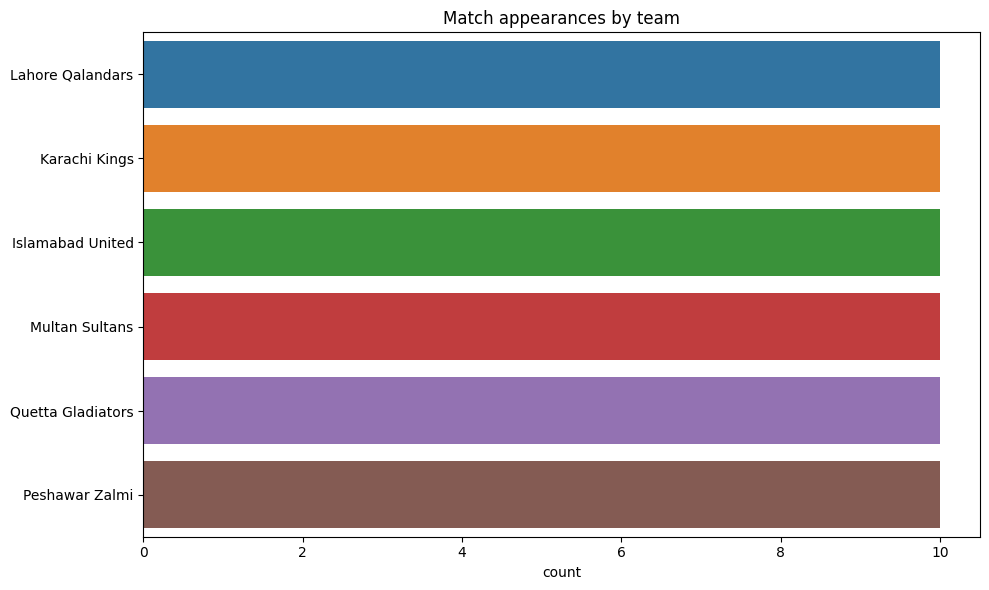

In [112]:
# Let's visualize number of matches per team (if columns exist)
if 'Team1' in df.columns and 'Team2' in df.columns:
    teams = pd.concat([df['Team1'], df['Team2']])
plt.figure(figsize=(10,6))
sns.countplot(y=teams)
plt.title('Match appearances by team')
plt.tight_layout()
plt.show()

In [114]:
print("Columns:", df.columns.tolist())
print("\nSample value counts for some likely columns (if present):")
for c in ['team1','team2','winner','result','venue','city','toss_winner','toss_decision','date']:
    if c in df.columns:
        print(f"\n== {c} ==\n", df[c].value_counts(dropna=False).head())


Columns: ['Match_ID', 'Date', 'Team1', 'Team2', 'Team1_Score', 'Team2_Score', 'Winner', 'Venue']

Sample value counts for some likely columns (if present):


# **Target extraction**


In [115]:
def extract_winner_from_result(row, team_cols):
    """Try to find which team name is present in the 'result' text"""
    res = str(row.get('result', '')).lower()
    for tcol in team_cols:
        team = str(row.get(tcol, '')).lower()
        if team and team in res:
            return row.get(tcol)
    # fallback heuristics
    m = re.search(r'(.+?) won', res)
    if m:
        return m.group(1).strip()
    return np.nan

# determine target
if 'Winner' in df.columns:
    target_col = 'Winner'
    print("Using existing 'winner' column.")
else:
    # attempt to create 'winner' from 'result'
    if 'result' in df.columns and ('Team1' in df.columns or 'Team2' in df.columns):
        team_cols = [c for c in ['Team1','Team2'] if c in df.columns]
        df['Winner'] = df.apply(lambda r: extract_winner_from_result(r, team_cols), axis=1)
        # If many NaNs remain, display counts
        print("Derived 'winner' from 'result'. Nulls:", df['Winner'].isna().sum(), " / ", len(df))
        target_col = 'Winner'
    else:
        # fallback: attempt common column names for winner
        for cand in ['match_winner', 'winning_team', 'ResultWinner']:
            if cand in df.columns:
                target_col = cand
                break
        else:
            raise ValueError("Couldn't find a suitable target column (like 'winner'). "
                             "Check df.columns and set target_col manually.")

# show class distribution
print("\nTarget distribution:")
print(df[target_col].value_counts(dropna=False).head(20))


Using existing 'winner' column.

Target distribution:
Winner
Islamabad United     9
Multan Sultans       8
Lahore Qalandars     4
Quetta Gladiators    4
Peshawar Zalmi       3
Karachi Kings        2
Name: count, dtype: int64


# **Feature selection**
We'll use these candidate features if present:
- team1, team2, toss_winner, toss_decision, venue, city, date, inning scores (if present), numeric match stats if available.
We automatically choose categorical vs numeric columns.

In [116]:
# Candidate features (in order of preference)
candidate_cols = ['Team1','Team2','Toss_winner','Toss_decision','Venue','City','Date',
                  'Team1_score','Team2_score','Team1_runs','Team2_runs','Winner']  # winner only to avoid using as feature
# Use intersection with df.columns
available = [c for c in candidate_cols if c in df.columns and c != target_col]
print("Available candidate features:", available)

# Build feature set
# We'll include all categorical string features except the target. Also include numeric columns if present (int/float).
categorical_cols = []
numeric_cols = []
for c in df.columns:
    if c == target_col:
        continue
    if c in available:
        if pd.api.types.is_numeric_dtype(df[c]):
            numeric_cols.append(c)
        else:
            categorical_cols.append(c)

# Also include other object-type columns that look relevant (team names etc)
# Limit total columns to a manageable number
print("Categorical cols detected:", categorical_cols)
print("Numeric cols detected:", numeric_cols)


Available candidate features: ['Team1', 'Team2', 'Venue', 'Date']
Categorical cols detected: ['Date', 'Team1', 'Team2', 'Venue']
Numeric cols detected: []


# **Preprocessing pipeline**
- Fill missing values (categorical -> 'missing', numeric -> median)
- OneHotEncode categorical features (drop='first' to reduce dims)
- Scale numeric features

In [117]:
# For this task we will:
# - encode categorical team/venue/city using OneHotEncoder
# - scale numeric with StandardScaler

# Final chosen columns
features = categorical_cols + numeric_cols
if len(features) == 0:
    raise ValueError("No features automatically selected. Inspect df.columns and adjust 'candidate_cols' list.")

print("Final features used:", features)

# Preprocessors
cat_transformer = Pipeline(steps=[
    ('imputer',      # fill missing
     (lambda: __import__('sklearn.impute', fromlist=['SimpleImputer']) or None)()), # dummy to avoid lint, replaced below
])

# I'll construct manually to avoid funky lambda: use SimpleImputer directly:
from sklearn.impute import SimpleImputer

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')  # drop other columns


Final features used: ['Date', 'Team1', 'Team2', 'Venue']


# **Train / Test Split**

In [118]:
# drop rows where target is missing
df_clean = df.dropna(subset=[target_col]).copy()
X = df_clean[features].copy()
y = df_clean[target_col].astype(str).copy()  # ensure string labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (24, 4) Test: (6, 4)


# **Training**

In [119]:
# RandomForest pipeline
rf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])



# Fit RandomForest
print("Training RandomForest...")
rf_pipeline.fit(X_train, y_train)
print("RandomForest trained.")



Training RandomForest...
RandomForest trained.


# **Evaluation**

=== RandomForest ===
Accuracy: 0.8333333333333334

Classification Report:
                   precision    recall  f1-score   support

 Islamabad United       1.00      1.00      1.00         2
 Lahore Qalandars       1.00      1.00      1.00         1
   Multan Sultans       0.67      1.00      0.80         2
Quetta Gladiators       0.00      0.00      0.00         1

         accuracy                           0.83         6
        macro avg       0.67      0.75      0.70         6
     weighted avg       0.72      0.83      0.77         6



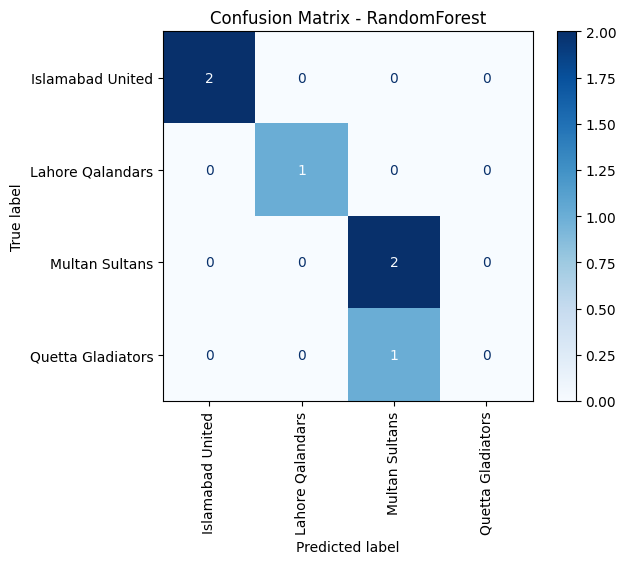

In [120]:
def evaluate_model(pipeline, X_test, y_test, model_name="Model"):
    preds = pipeline.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"=== {model_name} ===")
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test, preds, zero_division=0))
    cm = confusion_matrix(y_test, preds, labels=np.unique(y_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(xticks_rotation='vertical', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    return preds

rf_preds = evaluate_model(rf_pipeline, X_test, y_test, model_name="RandomForest")
# xgb_preds = evaluate_model(xgb_pipeline, X_test, y_test, model_name="XGBoost")


# **Save the model**

In [121]:
OUT_DIR = Path('/kaggle/working/models')
OUT_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(rf_pipeline, OUT_DIR / 'rf_pipeline.joblib')

print("Saved models to", OUT_DIR)


Saved models to /kaggle/working/models


# **Predict on unseen data**

In [122]:
# Example sample - adapt values according to actual categories in your dataset
sample = {
    features[0]: X_test.iloc[0][features[0]] if features else None
}
# More realistically create sample using first row of test set
sample_row = X_test.iloc[0:1].copy()
print("Sample row for prediction:")
display(sample_row)

rf_pred = rf_pipeline.predict(sample_row)

print("RF predicted winner:", rf_pred[0])


# If you want probabilities (for classes) - show top 3 probable teams
if hasattr(rf_pipeline, "predict_proba"):
    probs = rf_pipeline.predict_proba(sample_row)
    class_names = rf_pipeline.named_steps['clf'].classes_
    top_idx = np.argsort(probs[0])[::-1][:3]
    print("RF top predictions:")
    for i in top_idx:
        print(f"  {class_names[i]}: {probs[0][i]:.3f}")


Sample row for prediction:


,Date,Team1,Team2,Venue
8,2024-02-25,Karachi Kings,Quetta Gladiators,Karachi


RF predicted winner: Multan Sultans
RF top predictions:
  Multan Sultans: 0.370
  Peshawar Zalmi: 0.215
  Karachi Kings: 0.200


# **Save predictions/results**

In [123]:
# Save test predictions for later analysis/comparison
results_df = X_test.copy()
results_df['y_true'] = y_test.values
results_df['rf_pred'] = rf_preds
results_df.to_csv(OUT_DIR / 'test_results.csv', index=False)
print("Saved test predictions to", OUT_DIR / 'test_results.csv')


Saved test predictions to /kaggle/working/models/test_results.csv
